# Simulate data
This notebook generates simulated experiments by sampling from the VAE using the user selected template experiment as a guide for sampling

In [1]:
%load_ext autoreload
%autoreload 2

import os
import sys
import glob
import pandas as pd
import numpy as np
import random
import seaborn as sns
import umap
from keras.models import load_model
from sklearn.decomposition import PCA
import pickle

from plotnine import (ggplot,
                      labs,  
                      geom_line, 
                      geom_point,
                      geom_errorbar,
                      aes, 
                      ggsave, 
                      theme_bw,
                      theme,
                      xlim,
                      ylim,
                      facet_wrap,
                      scale_color_manual,
                      guides, 
                      guide_legend,
                      element_blank,
                      element_text,
                      element_rect,
                      element_line,
                      coords)

sys.path.append("../")
from functions import utils, generate_labeled_data

from numpy.random import seed
randomState = 123
seed(randomState)

/home/alexandra/anaconda3/envs/ranked_pathways/lib/python3.7/site-packages/matplotlib/__init__.py:886: MatplotlibDeprecationWarning: 
examples.directory is deprecated; in the future, examples will be found relative to the 'datapath' directory.
  "found relative to the 'datapath' directory.".format(key))
Using TensorFlow backend.


In [2]:
# Read in config variables
base_dir = os.path.abspath(os.path.join(os.getcwd(),"../"))

config_file = os.path.abspath(os.path.join(base_dir,
                                           "Rank_pathways",
                                           "init_config.tsv"))
params = utils.read_config(config_file)

In [3]:
# Load params
local_dir = params["local_dir"]
dataset_name = params['dataset_name']
NN_architecture = params['NN_architecture']
num_runs = 25

NN_dir = os.path.join(
    base_dir, 
    dataset_name, 
    "models", 
    NN_architecture)

# User selected experiment id
project_id = "SRP000762"

In [4]:
# Load real compendium
compendium_file = os.path.join(
    local_dir,
    "recount2_compedium_data.tsv")

normalized_compendium_file = os.path.join(
    local_dir,
    "normalized_recount2_compendium_data.tsv")

# Load real template experiment
template_data_file = os.path.join(
    local_dir,
    "recount2_template_data.tsv")

# Load pickled files
scaler_transform_file = os.path.join(
    local_dir,
    "scaler_transform.pickle")

scaler = pickle.load(open(scaler_transform_file, "rb" ) )

In [5]:
# Read data
compendium = pd.read_table(
    compendium_file,
    header=0,
    sep='\t',
    index_col=0)

normalized_compendium = pd.read_table(
    normalized_compendium_file,
    header=0,
    sep='\t',
    index_col=0)

template_data = pd.read_table(
    template_data_file,
    header=0,
    sep='\t',
    index_col=0)

### Simulate experiments using selected template experiment

In [6]:
# Simulate experiments
# Make sure range is correct
# Generate multiple simulated datasets
#for i in range(num_runs):
#    generate_labeled_data.shift_template_experiment(
#        normalized_compendium_file,
#        project_id,
#        NN_architecture,
#        dataset_name,
#        scaler,
#        local_dir,
#        base_dir,
#        i)

### Quick validation of simulated experiments

**Spot check expression values**
1. Values are different between different simulated data files (meaning it was a different simulated dataset), and different from the template experiment
2. Range of values is scaled the same as the compendium

In [7]:
# Compendium
print(compendium.shape)
compendium.head()

(1552, 58037)


,ENSG00000000003.14,ENSG00000000005.5,ENSG00000000419.12,ENSG00000000457.13,ENSG00000000460.16,ENSG00000000938.12,ENSG00000000971.15,ENSG00000001036.13,ENSG00000001084.10,ENSG00000001167.14,...,ENSG00000283690.1,ENSG00000283691.1,ENSG00000283692.1,ENSG00000283693.1,ENSG00000283694.1,ENSG00000283695.1,ENSG00000283696.1,ENSG00000283697.1,ENSG00000283698.1,ENSG00000283699.1
SRR1604987,35.467314,0.027332,32.157194,2.358523,2.588223,0.000000,5.738176,43.607106,6.178332,11.840453,...,0.000000,0.164063,0.0,0.0,0.000000,0.104461,0.108411,0.973816,0.001023,0.0
SRR1604988,36.738594,0.014175,31.768894,2.441588,2.879852,0.028577,5.801958,44.476582,5.770250,11.408501,...,0.005034,0.637123,0.0,0.0,0.000000,0.000000,0.126587,0.862680,0.000364,0.0
SRR1604989,23.421167,0.000000,26.339462,2.416182,2.935066,0.000000,4.173785,33.963581,8.310376,11.857877,...,0.000000,0.376129,0.0,0.0,0.000000,0.087597,0.338459,0.633735,0.034451,0.0
SRR1604990,22.413470,0.000000,26.680954,2.747019,3.281573,0.009275,4.233309,33.615684,8.207437,12.296103,...,0.000000,0.112437,0.0,0.0,0.165182,0.000000,0.252239,1.049893,0.004970,0.0
SRR1604991,22.274276,0.000000,28.510716,1.818116,2.095023,0.011248,3.693352,32.073188,4.571614,11.777791,...,0.000000,0.107868,0.0,0.0,0.000000,0.000000,0.179313,0.952988,0.111618,0.0


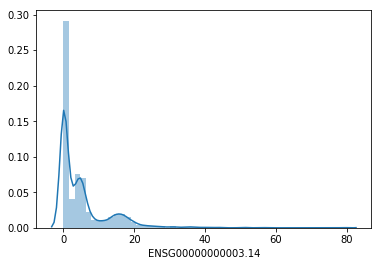

In [8]:
sns.distplot(compendium['ENSG00000000003.14'])

In [9]:
# Template experiment
print(template_data.shape)
template_data.head()

(23, 58037)


,ENSG00000000003.14,ENSG00000000005.5,ENSG00000000419.12,ENSG00000000457.13,ENSG00000000460.16,ENSG00000000938.12,ENSG00000000971.15,ENSG00000001036.13,ENSG00000001084.10,ENSG00000001167.14,...,ENSG00000283690.1,ENSG00000283691.1,ENSG00000283692.1,ENSG00000283693.1,ENSG00000283694.1,ENSG00000283695.1,ENSG00000283696.1,ENSG00000283697.1,ENSG00000283698.1,ENSG00000283699.1
SRR020495,12.282370,0.0,31.446772,1.750075,3.811501,0.073229,4.824045,24.524451,30.226917,5.570599,...,0.0,0.000000,0.000000,0.0,3.381246,0,0.459295,0.000000,0.000000,0.0
SRR020720,11.132876,0.0,28.697619,2.121440,3.957351,0.036476,5.537391,24.285190,32.023732,8.166891,...,0.0,0.000000,0.117783,0.0,0.000000,0,0.620834,0.856206,0.000000,0.0
SRR020721,9.865438,0.0,28.158251,2.284550,3.591547,0.052382,5.129456,24.274451,31.737892,7.420836,...,0.0,1.184731,0.027080,0.0,0.000000,0,0.117336,0.461084,0.000000,0.0
SRR020722,8.508080,0.0,27.298493,2.177740,4.115783,0.061880,5.245823,25.404100,32.221991,7.110850,...,0.0,2.171430,0.000000,0.0,0.000000,0,0.228686,0.319112,0.242553,0.0
SRR020735,10.556045,0.0,26.635241,1.808284,3.608147,0.000000,6.084540,24.608319,30.925295,7.768971,...,0.0,0.000000,0.000000,0.0,0.000000,0,0.000000,0.200928,0.000000,0.0


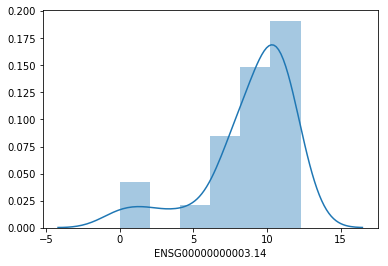

In [10]:
sns.distplot(template_data['ENSG00000000003.14'])

In [11]:
# Manual select one simulated experiment
simulated_file_1 = os.path.join(
    local_dir,
    "pseudo_experiment",
    "selected_simulated_data_SRP000762_0.txt")

# Read data
simulated_test_1 = pd.read_table(
    simulated_file_1,
    header=0,
    sep='\t',
    index_col=0)

print(simulated_test_1.shape)
simulated_test_1.head()

(23, 58037)


,ENSG00000000003.14,ENSG00000000005.5,ENSG00000000419.12,ENSG00000000457.13,ENSG00000000460.16,ENSG00000000938.12,ENSG00000000971.15,ENSG00000001036.13,ENSG00000001084.10,ENSG00000001167.14,...,ENSG00000283690.1,ENSG00000283691.1,ENSG00000283692.1,ENSG00000283693.1,ENSG00000283694.1,ENSG00000283695.1,ENSG00000283696.1,ENSG00000283697.1,ENSG00000283698.1,ENSG00000283699.1
SRR020495,0.579,0.017,24.394,2.463,1.675,2.037,0.048,11.327,1.005,4.868,...,0.000,0.096,0.002,0.030,0.008,0.009,0.048,0.797,0.055,0.006
SRR020720,0.823,0.018,27.114,2.268,1.799,2.485,0.087,15.845,1.377,6.783,...,0.001,0.185,0.004,0.067,0.012,0.013,0.781,0.630,0.055,0.015
SRR020721,0.421,0.010,22.803,2.494,1.715,1.711,0.041,9.757,0.799,4.325,...,0.000,0.065,0.001,0.012,0.005,0.008,0.011,0.817,0.043,0.004
SRR020722,0.382,0.010,21.159,2.366,1.595,1.815,0.037,9.057,0.729,4.182,...,0.000,0.063,0.001,0.015,0.005,0.008,0.009,0.785,0.046,0.004
SRR020735,0.642,0.019,25.542,2.560,1.760,2.176,0.061,11.857,1.083,5.218,...,0.000,0.106,0.002,0.030,0.008,0.010,0.064,0.763,0.054,0.007


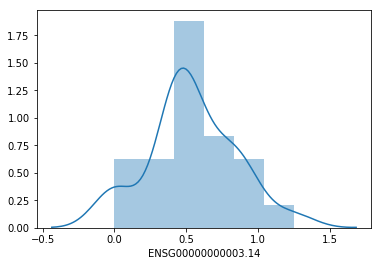

In [12]:
sns.distplot(simulated_test_1['ENSG00000000003.14'])

In [55]:
# Manual select another simulated experiment
simulated_file_2 = os.path.join(
    local_dir,
    "pseudo_experiment",
    "selected_simulated_data_SRP000762_10.txt")

# Read data
simulated_test_2 = pd.read_table(
    simulated_file_2,
    header=0,
    sep='\t',
    index_col=0)

print(simulated_test_2.shape)
simulated_test_2.head()

(23, 58037)


,ENSG00000000003.14,ENSG00000000005.5,ENSG00000000419.12,ENSG00000000457.13,ENSG00000000460.16,ENSG00000000938.12,ENSG00000000971.15,ENSG00000001036.13,ENSG00000001084.10,ENSG00000001167.14,...,ENSG00000283690.1,ENSG00000283691.1,ENSG00000283692.1,ENSG00000283693.1,ENSG00000283694.1,ENSG00000283695.1,ENSG00000283696.1,ENSG00000283697.1,ENSG00000283698.1,ENSG00000283699.1
SRR020495,0.030,0.0,15.681,2.285,3.252,6.037,0.002,2.777,0.108,3.878,...,0.0,0.002,0.0,0.009,0.001,0.001,0.000,0.920,0.013,0.002
SRR020720,0.054,0.0,13.161,1.633,2.935,4.281,0.003,3.604,0.102,2.941,...,0.0,0.010,0.0,0.009,0.001,0.003,0.013,0.769,0.009,0.004
SRR020721,0.018,0.0,16.194,2.463,3.287,5.933,0.001,2.452,0.079,3.918,...,0.0,0.001,0.0,0.005,0.001,0.001,0.000,0.949,0.009,0.001
SRR020722,0.015,0.0,15.338,2.391,3.035,6.349,0.001,2.395,0.073,3.998,...,0.0,0.001,0.0,0.005,0.001,0.001,0.000,0.955,0.010,0.001
SRR020735,0.035,0.0,16.161,2.306,3.294,6.045,0.002,2.729,0.115,3.760,...,0.0,0.002,0.0,0.008,0.001,0.001,0.002,0.901,0.012,0.002


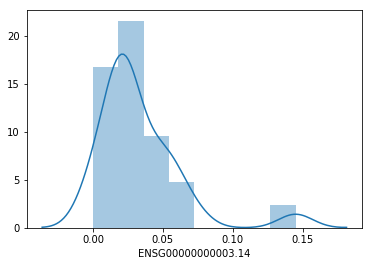

In [56]:
sns.distplot(simulated_test_2['ENSG00000000003.14'])

**Check clustering of simulated samples**

Check UMAP of original experiment and simulated experiments. Expect to see a similar structure in the template and simulated experiments. Also expect to see that the simulated experiment follows the distribution of the compendium.

**Visualization in latent space**

In [57]:
# Load VAE models
model_encoder_file = glob.glob(os.path.join(
        NN_dir,
        "*_encoder_model.h5"))[0]

weights_encoder_file = glob.glob(os.path.join(
    NN_dir,
    "*_encoder_weights.h5"))[0]

model_decoder_file = glob.glob(os.path.join(
    NN_dir,
    "*_decoder_model.h5"))[0]

weights_decoder_file = glob.glob(os.path.join(
    NN_dir,
    "*_decoder_weights.h5"))[0]

# Load saved models
loaded_model = load_model(model_encoder_file)
loaded_decode_model = load_model(model_decoder_file)

loaded_model.load_weights(weights_encoder_file)
loaded_decode_model.load_weights(weights_decoder_file)

In [58]:
pca = PCA(n_components=2)

In [59]:
# Embedding of real compendium (encoded)

# Scale compendium
compendium_scaled = scaler.transform(compendium)
compendium_scaled_df = pd.DataFrame(compendium_scaled,
                                    columns=compendium.columns,
                                    index=compendium.index)

# Encode compendium into latent space
compendium_encoded = loaded_model.predict_on_batch(compendium_scaled_df)

compendium_encoded_df = pd.DataFrame(data=compendium_encoded, 
                                     index=compendium.index)

# Get and save model
#model = umap.UMAP(random_state=randomState).fit(compendium_encoded_df)
model = pca.fit(compendium_encoded_df)

compendium_UMAPencoded = model.transform(compendium_encoded_df)

compendium_UMAPencoded_df = pd.DataFrame(data=compendium_UMAPencoded,
                                         index=compendium_encoded_df.index,
                                         columns=['1','2'])

# Add label
compendium_UMAPencoded_df['experiment_id'] = 'background'

In [60]:
# Embedding of real template experiment (encoded)

# Scale template data
template_data_scaled = scaler.transform(template_data)
template_data_scaled_df = pd.DataFrame(template_data_scaled,
                                    columns=template_data.columns,
                                    index=template_data.index)

# Encode template experiment into latent space
template_encoded = loaded_model.predict_on_batch(template_data_scaled)
template_encoded_df = pd.DataFrame(data=template_encoded,
                                   index=template_data.index)

template_UMAPencoded = model.transform(template_encoded_df)

template_UMAPencoded_df = pd.DataFrame(data=template_UMAPencoded,
                                         index=template_encoded_df.index,
                                         columns=['1','2'])

# Add back label column
template_UMAPencoded_df['experiment_id'] = 'template_experiment'

In [61]:
# Embedding of simulated experiment (encoded)

# Scale simulated data
simulated_test_2_scaled = scaler.transform(simulated_test_2)
simulated_test_2_scaled_df = pd.DataFrame(simulated_test_2_scaled,
                                          columns=simulated_test_2.columns,
                                          index=simulated_test_2.index)

# Encode simulated experiment into latent space
simulated_encoded = loaded_model.predict_on_batch(simulated_test_2_scaled)
simulated_encoded_df = pd.DataFrame(
    simulated_encoded, index=simulated_test_2.index)

simulated_UMAPencoded = model.transform(simulated_encoded_df)

simulated_UMAPencoded_df = pd.DataFrame(data=simulated_UMAPencoded,
                                         index=simulated_encoded_df.index,
                                         columns=['1','2'])

# Add back label column
simulated_UMAPencoded_df['experiment_id'] = 'simulated_experiment'

In [62]:
# Concatenate dataframes
combined_UMAPencoded_df = pd.concat([compendium_UMAPencoded_df, 
                                    template_UMAPencoded_df,
                                    simulated_UMAPencoded_df])

combined_UMAPencoded_df.shape

(1598, 3)

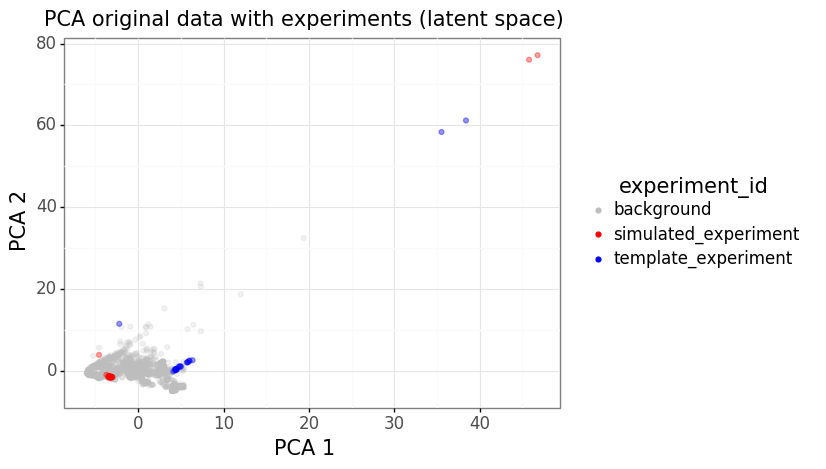

<ggplot: (8789854121001)>


In [63]:
# Plot
fig = ggplot(combined_UMAPencoded_df, aes(x='1', y='2'))
fig += geom_point(aes(color='experiment_id'), alpha=0.2)
fig += labs(x ='PCA 1',
            y = 'PCA 2',
            title = 'PCA original data with experiments (latent space)')
fig += theme_bw()
fig += theme(
    legend_title_align = "center",
    plot_background=element_rect(fill='white'),
    legend_key=element_rect(fill='white', colour='white'), 
    legend_title=element_text(family='sans-serif', size=15),
    legend_text=element_text(family='sans-serif', size=12),
    plot_title=element_text(family='sans-serif', size=15),
    axis_text=element_text(family='sans-serif', size=12),
    axis_title=element_text(family='sans-serif', size=15)
    )
fig += guides(colour=guide_legend(override_aes={'alpha': 1}))
fig += scale_color_manual(['#bdbdbd', 'red', 'blue'])
fig += geom_point(data=combined_UMAPencoded_df[combined_UMAPencoded_df['experiment_id'] == 'template_experiment'],
                  alpha=0.2, 
                  color='blue')
fig += geom_point(data=combined_UMAPencoded_df[combined_UMAPencoded_df['experiment_id'] == 'simulated_experiment'],
                  alpha=0.2, 
                  color='red')

print(fig)

**Visualization in gene space**

In [64]:
# Embedding of real compendium

# Get and save model
model = umap.UMAP(random_state=randomState).fit(compendium_scaled_df)

compendium_UMAPencoded = model.transform(compendium_scaled_df)

compendium_UMAPencoded_df = pd.DataFrame(data=compendium_UMAPencoded,
                                         index=compendium_scaled_df.index,
                                         columns=['1','2'])
# Add label
compendium_UMAPencoded_df['experiment_id'] = 'background'

In [65]:
# Embedding of real template experiment

template_UMAPencoded = model.transform(template_data_scaled_df)

template_UMAPencoded_df = pd.DataFrame(data=template_UMAPencoded,
                                         index=template_data_scaled_df.index,
                                         columns=['1','2'])

# Add back label column
template_UMAPencoded_df['experiment_id'] = 'template_experiment'

In [66]:
# Embedding of simulated template experiment

simulated_UMAPencoded = model.transform(simulated_test_2_scaled_df)

simulated_UMAPencoded_df = pd.DataFrame(data=simulated_UMAPencoded,
                                         index=simulated_test_2_scaled_df.index,
                                         columns=['1','2'])

# Add back label column
simulated_UMAPencoded_df['experiment_id'] = 'simulated_experiment'

In [67]:
# Concatenate dataframes
combined_UMAPencoded_df = pd.concat([compendium_UMAPencoded_df, 
                                    template_UMAPencoded_df,
                                    simulated_UMAPencoded_df])

combined_UMAPencoded_df.shape

(1598, 3)

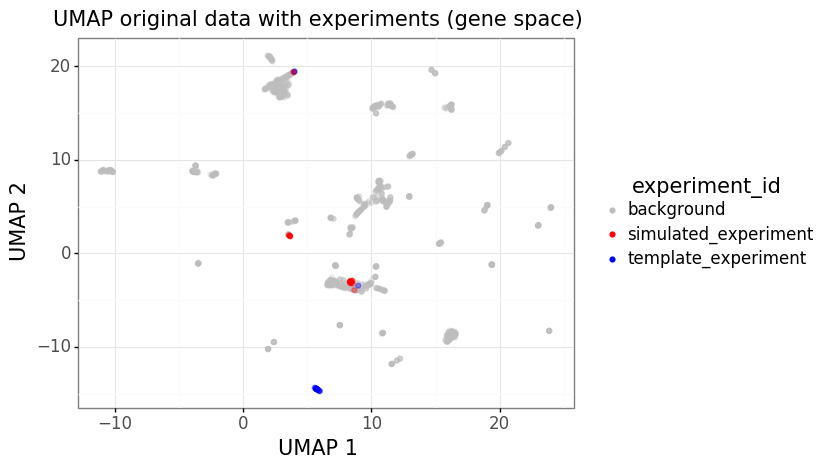

<ggplot: (8789846070365)>


In [68]:
# Plot
fig = ggplot(combined_UMAPencoded_df, aes(x='1', y='2'))
fig += geom_point(aes(color='experiment_id'), alpha=0.2)
fig += labs(x ='UMAP 1',
            y = 'UMAP 2',
            title = 'UMAP original data with experiments (gene space)')
fig += theme_bw()
fig += theme(
    legend_title_align = "center",
    plot_background=element_rect(fill='white'),
    legend_key=element_rect(fill='white', colour='white'), 
    legend_title=element_text(family='sans-serif', size=15),
    legend_text=element_text(family='sans-serif', size=12),
    plot_title=element_text(family='sans-serif', size=15),
    axis_text=element_text(family='sans-serif', size=12),
    axis_title=element_text(family='sans-serif', size=15)
    )
fig += guides(colour=guide_legend(override_aes={'alpha': 1}))
fig += scale_color_manual(['#bdbdbd', 'red', 'blue'])
fig += geom_point(data=combined_UMAPencoded_df[combined_UMAPencoded_df['experiment_id'] == 'template_experiment'],
                  alpha=0.2, 
                  color='blue')
fig += geom_point(data=combined_UMAPencoded_df[combined_UMAPencoded_df['experiment_id'] == 'simulated_experiment'],
                  alpha=0.2, 
                  color='red')

print(fig)